# Exp 12. 한국어 데이터로 챗봇 만들기

---

# 🗼 목차
**라이브러리 불러오기**  
**트랜스포머 이해하기**


**Step 1. 데이터 불러오기**
    
    
**Step 2. 데이터 전처리하기**
    
    
**Step 3. SubwordTextEncoder 사용하기**  
3.1 vocabulary 만들기  
3.2 Integer encoding & padding  
3.3 Teacher Forcing 사용하기
    
    
**Step 4. 모델 구성하기**  
4.1 트랜스포머 함수 정의  
4.2 모델 생성  
4.3 손실함수(Loss Function)  
4.4 커스텀된 학습률(Learning rate)  
4.5 모델 컴파일  
4.6 훈련하기  
    
    
**Step 5. 모델 평가하기**
    
    
**Step 6. 하이퍼파라미터 변경해서 진행**

---

# 라이브러리 불러오기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("슝=3")

슝=3


---

# 트랜스포머 이해하기

## Positional Encoding
* RNN 모델과 다르게 트랜스포머 모델의 입력 데이터 처리는 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다.
* 트랜스포머가 문장에 있는 모든 단어를 한꺼번에 입력으로 받는다.
* 그렇기에 어떤 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려주기 위해 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(positional Encoding) 값을 더해서 모델의 입력으로 삼는다.
* 임베딩 행렬과 포지셔널 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해주게 된다.
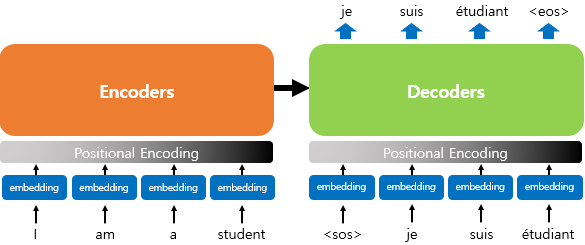

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


## Scaled Dot Product Attention

### * 트랜스포머에서 사용된 어텐션
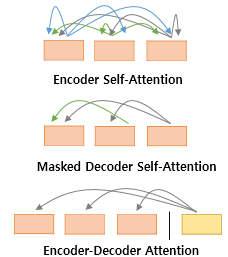 
- **인코더 셀프 어텐션** : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
- **디코더 셀프 어텐션** : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- **인코더-디코더 어텐션** : 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

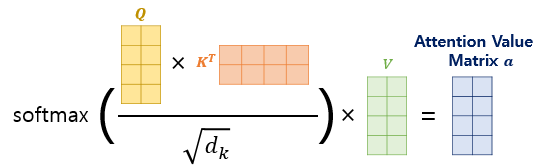

* 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구해서 '스케일드 닷 프로덕트 어텐션'이라고 한다.

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

      # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

     # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


## Multi head Attention
* 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있다.
* 각각 다른 관점에서 어텐션을 수행하기에 한 번의 어텐션만 수행했다면 놓칠 수 있는 정보를 캐치할 수 있다.
* 멀티 헤드 어텐션 함수 내부적으로 `스케일드 닷 프로덕트 어텐션`함수를 호출한다.

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

print("슝=3")

슝=3


## Masking
* 마스킹이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.
* 트랜스포머에서는 어텐션을 위해 2가지 마스킹을 사용한다.

### * Padding Masking
* 패팅 토큰(padding token)을 이용한 방법이다.  
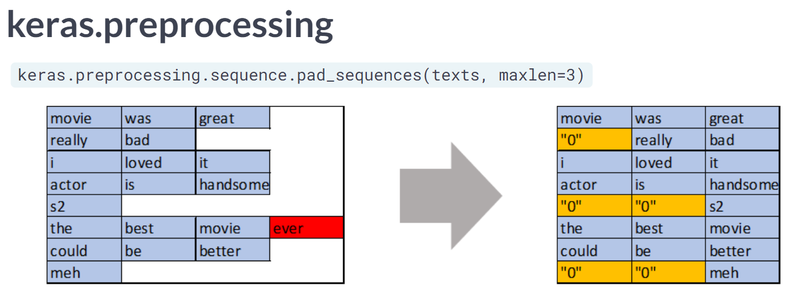

In [5]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


### * Look-ahead Masking
* 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이다.
* 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있다.  
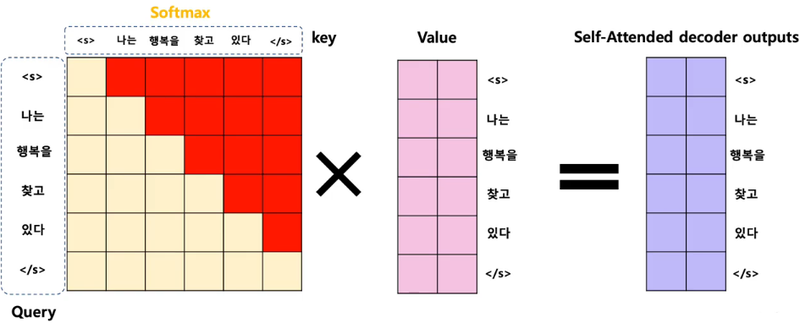

In [6]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
    
print("슝=3")

슝=3


## Encoder
* 인코더 층은 `셀프 어텐션`과 `피드 포워드 신경망` 총 2개의 서브 층으로 나누어진다.
* `셀프 어텐션`은 멀티 헤드 어텐션으로 병렬적으로 이루어진다.
* 인코더 층을 `임베딩 층`과 `포지셔널 인코딩`을 연결하고 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.
* 트랜스포머는 하이퍼파라미터`num_layers` 개수의 인코더 층을 쌓는다.
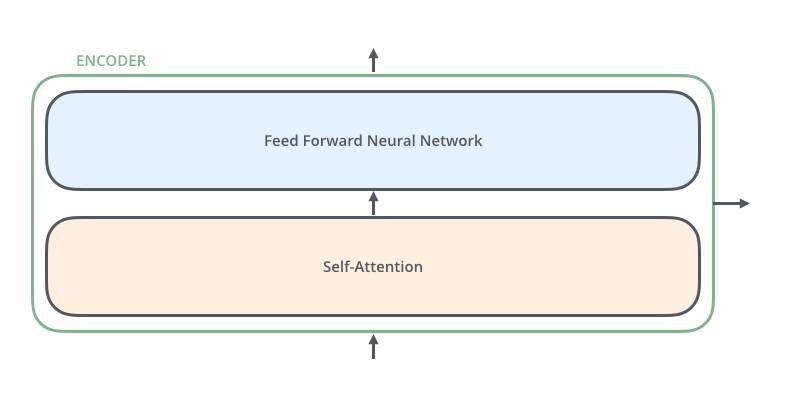

In [7]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어(셀프 어텐션, 피드 포워드 신경망)가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


## Decoder
* **인코더-디코더 어텐션**은 셀프 어텐션과는 다르게 **Query가 디코더의 벡터**인 반면, **Key와 Value가 인코더의 벡터**라는 특징이 있다. (이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.)
* 인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 모두 스케일드 닷 프로덕트 어텐션을 `멀티 헤드 어텐션`으로 병렬적으로 수행한다.
* 디코더의 층은 **임베딩 층(Embedding Layer)**과 **포지셔널 인코딩(Positional Encoding)**을 연결하고 사용자가 원하는 만큼 디코더 층을 쌓아 트렌스포머의 디코더가 완성된다.
* 인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓는다.
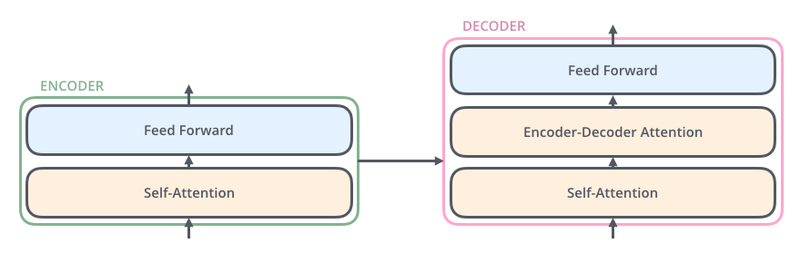

In [8]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
    })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
    })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

        return tf.keras.Model(
            inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
            outputs=outputs,
            name=name)
    
print("슝=3")

슝=3


---

# Step 1. 데이터 불러오기
* [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)에서 다운로드 할 수 있다.
* `label`은 총 3가지이다.
* 0 : 일상다반사 / 1: 이별(부정) / 2: 사랑(긍정)

In [9]:
dataset_filepath = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'

data = pd.read_csv(dataset_filepath)

In [10]:
# 일상다반사
data[0:10]

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [11]:
# 이별(부정)
data[8000:8010]

,Q,A,label
8000,전여친이 나보다 나은 사람이라는 생각이 자꾸 들어,남과 자신을 비교하지 말아요. 자신을 더 사랑해보세요.,1
8001,전여친이랑 낼 술한잔 하기로 했어,달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요.,1
8002,전여친한테 남친이 생겼네,이제 그녀를 잊으세요.,1
8003,전하지 못 할 편지,때론 묻어두는게 좋을 때도 있어요.,1
8004,전화가 왔는데 못받앗어,다시 연락하고 싶다면 전화해보세요.,1
8005,전화하고싶어,후회하지 않을 자신이 있다면 연락하세요.,1
8006,절대 사과 안하는 여자친구,잘못을 했을 때 인정하는 태도는 관계에서 중요한 역할을 합니다.,1
8007,절망적인데,탈출구가 있을 거예요.,1
8008,점심시간잠깐 그녀가 저에게 했던 말들이 떠오르네~ㅠㅠ,생각을 접어두는 것도 필요해요.,1
8009,점점 괜찮아 지는것 같다가도.,힘들기도 하겠죠.,1


In [12]:
# 사랑(긍정)
data[10000:10010]

,Q,A,label
10000,사랑한다고 말해주면 뭐가 덧나나,사랑한다고 표현해달라고 말해보세요.,2
10001,사랑한다고 말해줘,사랑해요.,2
10002,사랑한다고 어떻게 표현하지?,머릿속에 맴도는 것들을 입으로 내뱉는 거죠.,2
10003,사랑한다는 걸 느끼는순간,받은 거보다 더 많이 해주고싶을 때요.,2
10004,사랑한다는 말 쉽게 안 나와,감정을 표현한다는게 어렵죠.,2
10005,사랑한다는 말 아껴야할까?,사랑한다는 말 아끼지 말고 언제든지 표현해주세요.,2
10006,사랑할 때도 용기가 필요하지?,당연하죠.,2
10007,사랑할 시간이 없어.,나를 사랑하고 상대를 사랑하는 여유를 갖게 되길 바라요.,2
10008,사랑할 여유가 없어,나를 사랑하고 상대를 사랑하는 여유를 갖게 되길 바라요.,2
10009,사랑할 자격이 있나?,사랑에 자격이 필요한가요.,2


---

# Step 2. 데이터 전처리하기
* 단어와 구두점 사이의 공백을 추가, 한글,영어,숫자,?.!, 이외의 문자는 공백으로 변경하는 전처리를 진행하였다.  
    
    
* `PyKoSpacing` 한국어 전처리 패키지를 사용하고자 하였다.
    * 정수 인코딩을 한 후에 잘 되었는지 확인하는데, 어떤 문장은 띄어쓰기가 인코딩이 되었고 어떤 문장인 되지 않았기에 띄어쓰기에 문제가 있는 것으로 판단을 하였다.
    * 하지만 그것이 어떠한 문제인지 명확하게 알 수가 없었다.
    * 그래서 `한국어 띄어쓰기 패키지`를 활용하면 이 문제를 해결할 수 있지 않을까라는 생각으로 시도해보았지만 설치 후 임포트하는데 자꾸 에러가 발생하여 결국 하지 못하였다.
    * [PyKoSpacing 한국어 전처리 패키지](https://velog.io/@ganta/%ED%95%9C%EA%B5%AD%EC%96%B4-%EC%A0%84%EC%B2%98%EB%A6%AC-%ED%8C%A8%ED%82%A4%EC%A7%80Text-Preprocessing-Tools-for-Korean-Text)

In [13]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [14]:
# from pykospacing import spacing

# new_data = data.replace(" ", '') # 띄어쓰기가 없는 문장으로 만들기
# kospacing_data = spacing(new_data) # 다시 띄어쓰기 진행

In [15]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()   # 영어 포함 시 소문자 변환, 양쪽 공백 제거

    # 단어와 구두점 사이에 공백을 추가함
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, 영어, 숫자, ?.!,를 제외한 나머지 문자를 공백으로 변경
    sentence = re.sub(r'[^가-힣a-zA-Z0-9?.!,]+'," ",sentence)
    sentence = sentence.strip()
    return sentence

print("슝=3")

슝=3


In [16]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    with open(dataset_filepath, 'r') as file:
        lines = file.readlines()
        
    conversation = []
    for line in lines[1:]:
        parts = line.split(',')
        conversation.append([line for line in parts[0:2]])

        
    for i in range(len(conversation) - 1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(conversation[i][0]))
        outputs.append(preprocess_sentence(conversation[i][1]))
        
    return inputs, outputs

In [17]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('질문 샘플 수 :', len(questions))
print('답변 샘플 수 :', len(answers))

질문 샘플 수 : 11822
답변 샘플 수 : 11822


In [18]:
print('전처리 후의 5번째 질문 샘플: {}'.format(questions[4]))
print('전처리 후의 5번째 답변 샘플: {}'.format(answers[4]))

전처리 후의 5번째 질문 샘플: ppl 심하네
전처리 후의 5번째 답변 샘플: 눈살이 찌푸려지죠 .


▶ 대문자가 소문자로 변경, 단어와 구두점 사이에 공백이 추가된 것을 확인할 수 있다.

In [19]:
print('전처리 후의 8009번째 질문 샘플: {}'.format(questions[8008]))
print('전처리 후의 8009번째 답변 샘플: {}'.format(answers[8808]))

전처리 후의 8009번째 질문 샘플: 점심시간잠깐 그녀가 저에게 했던 말들이 떠오르네
전처리 후의 8009번째 답변 샘플: 찾으려고 노력하지 마세요 .


▶ ~(?.!, 이외의 특수문자)과 ㅠㅠ가 제거된 것을 확인할 수 있다. (ㅠㅠ는 한글이라고 치지 않는 것인가..?)

In [20]:
print('전처리 후의 10003번째 질문 샘플: {}'.format(questions[10002]))
print('전처리 후의 10003번째 답변 샘플: {}'.format(answers[10002]))

전처리 후의 10003번째 질문 샘플: 사랑한다고 어떻게 표현하지 ?
전처리 후의 10003번째 답변 샘플: 머릿속에 맴도는 것들을 입으로 내뱉는 거죠 .


▶ ?는 제거되지 않은 것을 확인할 수 있다.

---

# Step 3. SubwordTextEncoder 사용하기
* 형태소 분석기말고 실습에서 사용했던 내부단어 토크나이저인 `SubwordTextEncoder`를 사용해보자.
* `SubwordTextEncoder`는 자주 사용되는 서브워드 단위로 토큰을 분리하는 토크나이저로 학습 데이터로부터 학습하여 서브워드로 구성된 단어 집합을 생성한다.

## 3.1 vocabulary 만들기
* 서브워드들로 이루어진 단어 집합(Vocabulary)를 생성하고, 각 서브워드에 고유한 정수를 부여한다.

In [21]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [22]:
print(tokenizer.subwords[:50])

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_', '이_', ' . ', '을_', '잘_', '도_', '고_', '요', '것_', '많이_', '안_', '좋은_', '같아요', '한_', '좀_', '싶어', '있어요', '가_', '나_', '있을_', '에_', '지_', '해보세요', '사람_', '할_', '은_', '같아', '해', '네', '면_', ' !', '사람이_', '를_', '건_', '마세요', '다_', '하고_', '지', '하는_', '보세요', '죠']


In [23]:
print('subwords의 크기 :', len(tokenizer.subwords))

subwords의 크기 : 7881


In [24]:
print('단어 장의 크기 :', tokenizer.vocab_size)

단어 장의 크기 : 8138


**❓ subwords와 vocabulary의 크기가 차이나는 이유는 무엇일까?**
(자세한 건 회고에서)

In [25]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여함
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN 번호 : ', [tokenizer.vocab_size])
print('END_TOKEN 번호 : ', [tokenizer.vocab_size + 1])

START_TOKEN 번호 :  [8138]
END_TOKEN 번호 :  [8139]


In [26]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정함
VOCAB_SIZE = tokenizer.vocab_size + 2
print('시작토큰, 종료토큰을 추가한 단어장 크기 : ', VOCAB_SIZE)

시작토큰, 종료토큰을 추가한 단어장 크기 :  8140


## 3.2 Integer encoding & padding
* `tokenizer.encode()`로 각 단어를 정수로 변환할 수 있고 또는 `tokenizer.decode()`를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

In [27]:
print('전처리 후의 5번째 질문 샘플: {}'.format(questions[4]))
print('전처리 후의 5번째 답변 샘플: {}'.format(answers[4]))
print('-------------------------------------')
print('정수 인코딩 후의 5번째 질문 샘플: {}'.format(tokenizer.encode(questions[4])))
print('정수 인코딩 후의 5번째 답변 샘플: {}'.format(tokenizer.encode(answers[4])))

전처리 후의 5번째 질문 샘플: ppl 심하네
전처리 후의 5번째 답변 샘플: 눈살이 찌푸려지죠 .
-------------------------------------
정수 인코딩 후의 5번째 질문 샘플: [7994, 7994, 7990, 7914, 4162]
정수 인코딩 후의 5번째 답변 샘플: [978, 2287, 1484, 2173, 5441, 50, 1]


In [28]:
Q_sample_string = questions[4]

Q_tokenized_string = tokenizer.encode(Q_sample_string)
print('정수 인코딩 후의 5번째 질문 샘플 : {}'.format(Q_tokenized_string))

Q_original_string = tokenizer.decode(Q_tokenized_string)
print('기존 5번째 질문 샘플 : {}'.format(Q_original_string))

for ts in Q_tokenized_string:
    print('{} -----> {}'.format(ts, tokenizer.decode([ts])))

정수 인코딩 후의 5번째 질문 샘플 : [7994, 7994, 7990, 7914, 4162]
기존 5번째 질문 샘플 : ppl 심하네
7994 -----> p
7994 -----> p
7990 -----> l
7914 ----->  
4162 -----> 심하네


In [29]:
Q_7_sample_string = questions[7]

Q_7_tokenized_string = tokenizer.encode(Q_7_sample_string)
print('정수 인코딩 후의 7번째 질문 샘플 : {}'.format(Q_7_tokenized_string))

Q_7_original_string = tokenizer.decode(Q_7_tokenized_string)
print('기존 7번째 질문 샘플 : {}'.format(Q_7_original_string))

for ts in Q_7_tokenized_string:
    print('{} -----> {}'.format(ts, tokenizer.decode([ts])))

정수 인코딩 후의 7번째 질문 샘플 : [1935, 642, 1118, 7914, 66, 5092]
기존 7번째 질문 샘플 : sns 맞팔 왜 안하지
1935 -----> sns 
642 -----> 맞
1118 -----> 팔
7914 ----->  
66 -----> 왜 
5092 -----> 안하지


* ppl의 경우, 한 단어로 인코딩 되지 않고 p,p,l 이렇게 따로 인코딩 된 것을 볼 수 있다. * 그래서 영어 약어도 동일한 문제가 발생하는지 sns을 확인해보았으나 이것은 하나로 인코딩 된 것을 볼 수 있다.
* 이것을 해결할 방법을 찾다가 `Customized KoNLPy` 한국어 전처리 패키지를 찾았다.
* 형태소 분석기에 사용자 사전을 추가하는 패키지로 `ppl` 단어를 추가하면 되겠다는 생각으로 시도해보았으나 결국 잘 되지 않았다.
* [Customized KoNLPy 한국어 전처리 패키지](https://data-science-hi.tistory.com/44)

In [30]:
A_sample_string = answers[4]

A_tokenized_string = tokenizer.encode(A_sample_string)
print('정수 인코딩 후의 5번째 답변 샘플 : {}'.format(Q_tokenized_string))

A_original_string = tokenizer.decode(A_tokenized_string)
print('기존 5번째 답변 샘플 : {}'.format(A_original_string))

for ts in A_tokenized_string:
    print('{} -----> {}'.format(ts, tokenizer.decode([ts])))

정수 인코딩 후의 5번째 답변 샘플 : [7994, 7994, 7990, 7914, 4162]
기존 5번째 답변 샘플 : 눈살이 찌푸려지죠 .
978 -----> 눈
2287 -----> 살이 
1484 -----> 찌
2173 -----> 푸
5441 -----> 려지
50 -----> 죠
1 ----->  .


In [31]:
Q_len = [len(s.split()) for s in data['Q']]
A_len = [len(s.split()) for s in data['A']]

print('질문의 최소 길이 : {}'.format(np.min(Q_len)))
print('질문의 최대 길이 : {}'.format(np.max(Q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(Q_len)))

print('-----------------------')

print('답변의 최소 길이 : {}'.format(np.min(A_len)))
print('답변의 최대 길이 : {}'.format(np.max(A_len)))
print('답변의 평균 길이 : {}'.format(np.mean(A_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097
-----------------------
답변의 최소 길이 : 1
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6936479742874058


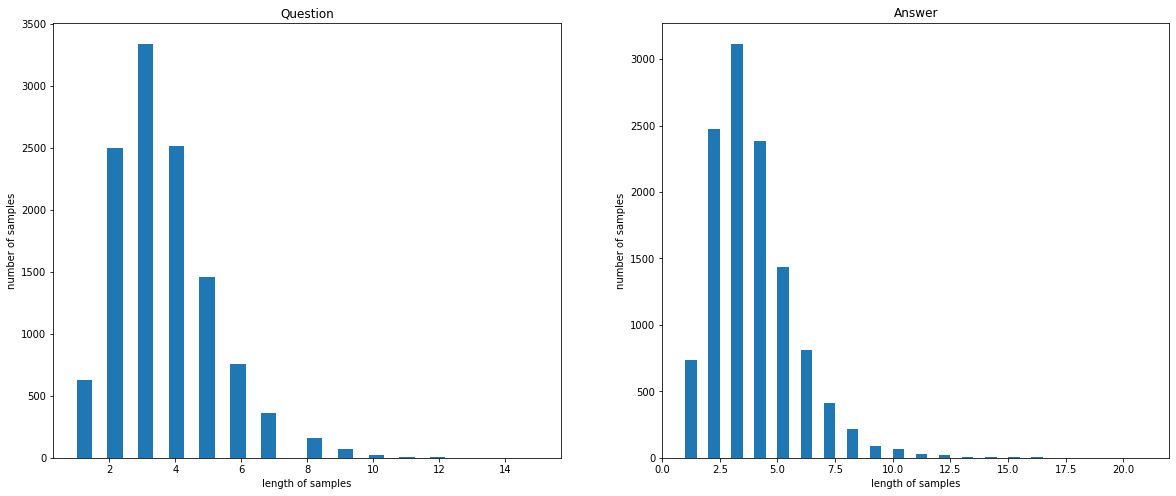

In [32]:
plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
plt.hist(Q_len, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title('Question')

plt.subplot(1,2,2)
plt.hist(A_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title('Answer')

plt.show()

In [33]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 11
print(MAX_LENGTH)

11


* 질문과 답변의 길이 분포를 확인해보았다. 질문의 평균 길이는 3으로 매우 짧았으나 최대 길이가 길고 최대한 데이터를 보존하기로 했다. 
* 질문의 경우 10 이후부터는 거의 데이터가 없으나 답변은 12 이후부터 거의 데이터가 없기에 '최대 길이'를 11로 설정하였다.

In [34]:
# below_threshold_len : 데이터의 몇 %가 최대 길이 안에 들어오는지 계산하는 함수

def below_threshold_len(MAX_LENGTH, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= MAX_LENGTH):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(MAX_LENGTH, (cnt / len(nested_list))))
print('슝=3')

슝=3


In [35]:
below_threshold_len(MAX_LENGTH, data['Q'])
below_threshold_len(MAX_LENGTH,  data['A'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9993233527869407
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9960246976232766


In [36]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 12 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 12으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

print("슝=3")

슝=3


In [37]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8140
필터링 후의 질문 샘플 개수: 10166
필터링 후의 답변 샘플 개수: 10166


* 필터링하고 난 후 샘플의 개수가 11822 → 10166개로 줄어든 것을 확인할 수 있다.

In [38]:
print(questions[4])
print(answers[4])

[8138 7994 7994 7990 7914 4162 8139    0    0    0    0]
[8138  978 2287 1484 2173 5441   50    1 8139    0    0]


* padding도 잘 된 것을 확인할 수 있다.

## 3.3 Teacher Forcing 사용하기
* 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블, 즉 실제 알고 있는 정답을 t+1 시점의 입력으로 사용한다.
* 교사 강요를 위해서 `answers[:, :-1]`를 디코더의 입력값, `answers[:, 1:]`를 디코더의 레이블로 사용한다.

In [39]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [40]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거

[8138 3816   75 7857    1 8139    0    0    0    0    0]
[[8138 3816   75 7857    1 8139    0    0    0    0]]
[[3816   75 7857    1 8139    0    0    0    0    0]]


* 디코더의 입력값인 `answers[:, :-1]`, 디코더의 레이블인 `answers[:, 1:]`을 확인해보았다.
* 디코더의 입력값은 마지막 패딩 토큰이 제거되었으며, 디코더의 레이블는 맨 처음 토큰이 제거되었다.

---

# Step 4. 모델 구성하기

## 4.1 트랜스포머 함수 정의
* 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 정의한다.

In [41]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

print("슝=3")

슝=3


## 4.2 모델 생성

In [42]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3138048     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 4.3 손실함수(Loss Function)
* 레이블인 시퀀스에 패딩이 되어 있으므로 , loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [43]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

print("슝=3")

슝=3


## 4.4 커스텀된 학습률(Learning rate)
* 모델 학습 초기에 learning rate를 급격히 높였다가 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하는 기법

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

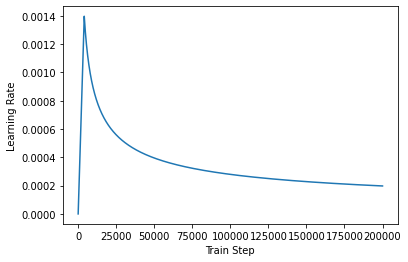

In [45]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

* learning rate를 시각화한 그래프를 확인해보면 처음에는 급격히 올라갔다가 train step을 지나면서 learning rate가 점점 낮아진다.

## 4.5 모델 컴파일

In [46]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


## 4.6 훈련하기

In [47]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
159/159 [==============================] - 8s 23ms/step - loss: 5.2384 - accuracy: 0.1028
Epoch 2/50
159/159 [==============================] - 4s 22ms/step - loss: 4.3172 - accuracy: 0.1907
Epoch 3/50
159/159 [==============================] - 4s 22ms/step - loss: 3.5923 - accuracy: 0.1934
Epoch 4/50
159/159 [==============================] - 4s 22ms/step - loss: 3.2400 - accuracy: 0.2029
Epoch 5/50
159/159 [==============================] - 4s 22ms/step - loss: 3.0210 - accuracy: 0.2137
Epoch 6/50
159/159 [==============================] - 4s 23ms/step - loss: 2.8125 - accuracy: 0.2297
Epoch 7/50
159/159 [==============================] - 4s 23ms/step - loss: 2.5915 - accuracy: 0.2524
Epoch 8/50
159/159 [==============================] - 4s 23ms/step - loss: 2.3505 - accuracy: 0.2806
Epoch 9/50
159/159 [==============================] - 4s 23ms/step - loss: 2.0888 - accuracy: 0.3107
Epoch 10/50
159/159 [==============================] - 4s 23ms/step - loss: 1.8122 - accura

# Step 5. 모델 평가하기

In [48]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

print("슝=3")

슝=3


In [49]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

print("슝=3")

슝=3


In [50]:
sentence_generation('오늘 하루는 어땠어?')

입력 : 오늘 하루는 어땠어?
출력 : 재밌는 일을 해보는 건 어떨까요 .


'재밌는 일을 해보는 건 어떨까요 .'

In [51]:
sentence_generation('기분이 어때?')

입력 : 기분이 어때?
출력 : 괜찮은 사람이에요 .


'괜찮은 사람이에요 .'

In [52]:
sentence_generation('졸려')

입력 : 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [53]:
sentence_generation('잠이 쏟아져')

입력 : 잠이 쏟아져
출력 : 부담갖지 말고 자는 것도 좋아요 .


'부담갖지 말고 자는 것도 좋아요 .'

In [54]:
sentence_generation('너무 잠이 오는데 어떻게 하면 좋을까?')

입력 : 너무 잠이 오는데 어떻게 하면 좋을까?
출력 : 고민이 되시겠어요 .


'고민이 되시겠어요 .'

---

# Step 6. 하이퍼파라미터 변경해서 진행
* `NUM_LAYERS`와 `D_MODEL`을 논문과 같이 변경해보았다.

In [55]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model_2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model_2.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13635584    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [56]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0173 - accuracy: 0.6174
Epoch 2/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0166 - accuracy: 0.6177
Epoch 3/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0161 - accuracy: 0.6177
Epoch 4/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0157 - accuracy: 0.6180
Epoch 5/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0153 - accuracy: 0.6179
Epoch 6/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0142 - accuracy: 0.6182
Epoch 7/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0144 - accuracy: 0.6180
Epoch 8/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0137 - accuracy: 0.6181
Epoch 9/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0138 - accuracy: 0.6183
Epoch 10/50
159/159 [==============================] - 4s 23ms/step - loss: 0.0127 - accura

In [57]:
sentence_generation('오늘 하루는 어땠어?')

입력 : 오늘 하루는 어땠어?
출력 : 재밌는 일을 해보는 건 어떨까요 .


'재밌는 일을 해보는 건 어떨까요 .'

In [58]:
sentence_generation('기분이 어때?')

입력 : 기분이 어때?
출력 : 혼자가 아니에요 .


'혼자가 아니에요 .'

In [59]:
sentence_generation('졸려')

입력 : 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [60]:
sentence_generation('잠이 쏟아져')

입력 : 잠이 쏟아져
출력 : 부담갖지 말고 자는 것도 좋아요 .


'부담갖지 말고 자는 것도 좋아요 .'

In [61]:
sentence_generation('너무 잠이 오는데 어떻게 하면 좋을까?')

입력 : 너무 잠이 오는데 어떻게 하면 좋을까?
출력 : 알면 도움이 되겠죠 .


'알면 도움이 되겠죠 .'

---

# 🌞 회고

# 1) 프로젝트 결과

* `max_len(최대길이)`을 처음에는 12으로 해서 진행을 하였는데, accuracy가 0.55 정도로 나왔다. epoch도 50으로 올렸지만 accuracy가 0.60 이상으로 나오지 않았다.
* 그래서 `max_len(최대길이)`을 11로 변경하여 진행하였으며 accuracy가 0.61이 나왔다.
* 하지만 챗봇 답변이 엄청 자연스러워졌다고는 할 수 없었다. 때로는 알맞은 답변이 나올 때도 있지만 아닌 답변일때도 있다.
* 이를 통해 정확도는 큰 의미가 없다고 생각되었다.
       
       
* 또 하나 실험을 해보았다.
    * 단순히 "졸려"라고 했을 때는 전반적으로 알맞은 답변이 나왔다.
    * 그래서 유사하지만 다른 단어를 사용한 문장을 입력해보았더니 생각보다 답변이 좋지 않았다.
* 문장이 길어질수록, 문장 내에 여러 단어가 많을수록 더욱 답변이 벗어난다는 것을 확인할 수 있었다.
    
    
* step 6에서 NUM_LAYERS와 D_MODEL을 논문과 같이 변경해보았는데 변경 전과 출력된 답변의 차이가 많이 없었고 accuracy도 비슷해서 하이퍼파라미터 변경은 큰 영향을 주지 않는 것같다.

# 2) 어려웠던 점

* 사실 이번 프로젝트는 이론적인 부분이 많이 어려웠다. 처음 보고 이해하기 어려운 부분이 많아서 쉽지 않았다.
* 이론을 바탕으로 구현된 코드를 보는데도 코드에 대해 명확하게 이해가 되지 않았다. 
* 전처리에서 의아한 부분들, 전처리가 잘 되지 않은 부분들을 해결하기 위해서 '한국어 전처리 패키지'를 활용해서 전처리해보고자 하였는데 쉽게 잘 되지는 않았다.
    * PyKoSpacing
    * Customized KoNLPy
    * 위의 전처리 패키지를 활용해서 전처리를 다시 해보고 싶다. 혹시 결과가 달라질지도 모르니..!  
    
    
*  `SubwordTextEncoder`를 활용하여 단어장을 만들 때 하나의 궁금증이 생겼다.
    * subwords와 vocabulary의 크기가 차이나는 이유는 무엇일까?
    * 단어 분리 작업은 하나의 단어를 여러 내부 단어로 분리해서 단어를 이해해보겠다는 의도를 가진 전처리 작업이라 분리된 내부단어(subwords)를 조합해서 단어장을 만들기에 단어장의 크기가 더 큰 것일까?

# 3) 후기

* 자연어는 아직 공부할게 매우 많다는 것을 알게된 프로젝트였다.
* 그래도 나름 이전 익스에서 활용했던 코드를 이번 익스에서 활용해보았는데, 나름 뿌듯했다.
* 생각보다 알맞은 답변들이 나와서 너무나 신기했다. 하지만 문장이 길어질 경우에는 답변이 이상해지곤 했는데, 모델 성능을 더 좋아야 가능한 이야기이지 않을까 싶다.
* 이번 프로젝트로 트랜스포머에 대해 살~짝 맛보기한 것 같다. 좀 더 상세하게 트랜스포머에 대해 공부하고 싶다.

# 4) 참고 자료
* [Transformer Chatbot Tutorial](https://wikidocs.net/89786)
* [한글 기본 정규표현식](https://superfelix.tistory.com/70)
* [PyKoSpacing 한국어 전처리 패키지](https://velog.io/@ganta/%ED%95%9C%EA%B5%AD%EC%96%B4-%EC%A0%84%EC%B2%98%EB%A6%AC-%ED%8C%A8%ED%82%A4%EC%A7%80Text-Preprocessing-Tools-for-Korean-Text)
* [Customized KoNLPy 한국어 전처리 패키지](https://data-science-hi.tistory.com/44)
* [SubWordText Encoder](https://wikidocs.net/86792)

## +) 추가로 보면 좋을 논문
* [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
* [Attention Is All You Need 리뷰 포스팅](https://reniew.github.io/43/)